In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

def plotLoss(losses):
    plt.figure(dpi=90)
    plt.plot(losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def displayImage(image, label):
        plt.imshow(image.numpy().squeeze().reshape(28,28), cmap='gray')
        plt.title(label)
        plt.axis('off')

def displaySamples(n, **rows):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        j = 0
        for key, value in rows.items():
            plt.subplot(len(rows), n, i + n*j + 1)
            displayImage(value[i], key)
            j += 1
    plt.show()

class ModelPersistence:
    @staticmethod
    def load(model):
        result = model().to(device)
        state_dict = torch.load(result.path)
        result.load_state_dict(state_dict)
        return result
    
    @staticmethod
    def save(model):
        torch.save(model.state_dict(), model.path)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [2]:
def flatten(tensor):
    return tensor.view(-1)

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(torch.flatten)
])

batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
class Encoder(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),     
            nn.Linear(512, 256),
            nn.ReLU(),     
            nn.Linear(256, 128),
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/encoder.pth'

    def forward(self, x):
        x = self.layers(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Decoder, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),     
            nn.Linear(256, 512),  
            nn.ReLU(),     
            nn.Linear(512, 784),  
            nn.Sigmoid(),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/decoder.pth'

    def forward(self, x):
        x = self.layers(x)
        return x
    
class Denoiser(nn.Module):
    def __init__(self, learning_rate = 0.001):
        super(Denoiser, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),     
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.path = 'data/denoiser.pth'

    def forward(self, x):
        x = self.layers(x)
        return x

100%|██████████| 938/938 [00:04<00:00, 224.56it/s]


Epoch [1/10], Loss: 0.0379


100%|██████████| 938/938 [00:04<00:00, 231.95it/s]


Epoch [2/10], Loss: 0.0223


100%|██████████| 938/938 [00:04<00:00, 222.91it/s]


Epoch [3/10], Loss: 0.0177


100%|██████████| 938/938 [00:04<00:00, 223.71it/s]


Epoch [4/10], Loss: 0.0177


100%|██████████| 938/938 [00:04<00:00, 221.98it/s]


Epoch [5/10], Loss: 0.0139


100%|██████████| 938/938 [00:04<00:00, 219.59it/s]


Epoch [6/10], Loss: 0.0113


100%|██████████| 938/938 [00:04<00:00, 224.96it/s]


Epoch [7/10], Loss: 0.0095


100%|██████████| 938/938 [00:04<00:00, 223.83it/s]


Epoch [8/10], Loss: 0.0088


100%|██████████| 938/938 [00:04<00:00, 217.53it/s]


Epoch [9/10], Loss: 0.0078


100%|██████████| 938/938 [00:04<00:00, 207.59it/s]

Epoch [10/10], Loss: 0.0096


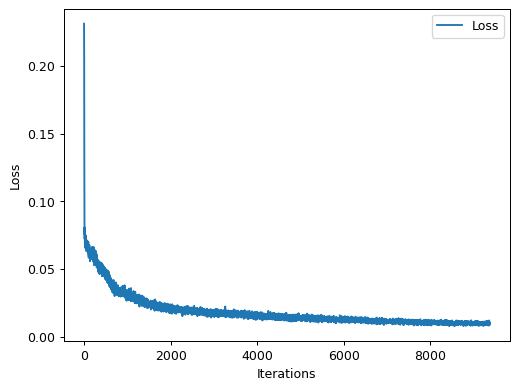

In [4]:
learning_rate = 0.001
epochs = 10

encoder = Encoder(learning_rate).to(device)
decoder = Decoder(learning_rate).to(device)
criterion = nn.MSELoss()

losses = []

for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, _ = data

        images = images.to(device)

        encoder.zero_grad()
        decoder.zero_grad()
        
        encodedImages = encoder(images)
        outputs = decoder(encodedImages)

        loss = criterion(outputs, images)

        loss.backward()
        losses.append(loss.item())
        encoder.optimizer.step()
        decoder.optimizer.step()

    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

ModelPersistence.save(encoder)
ModelPersistence.save(decoder)

plotLoss(losses)

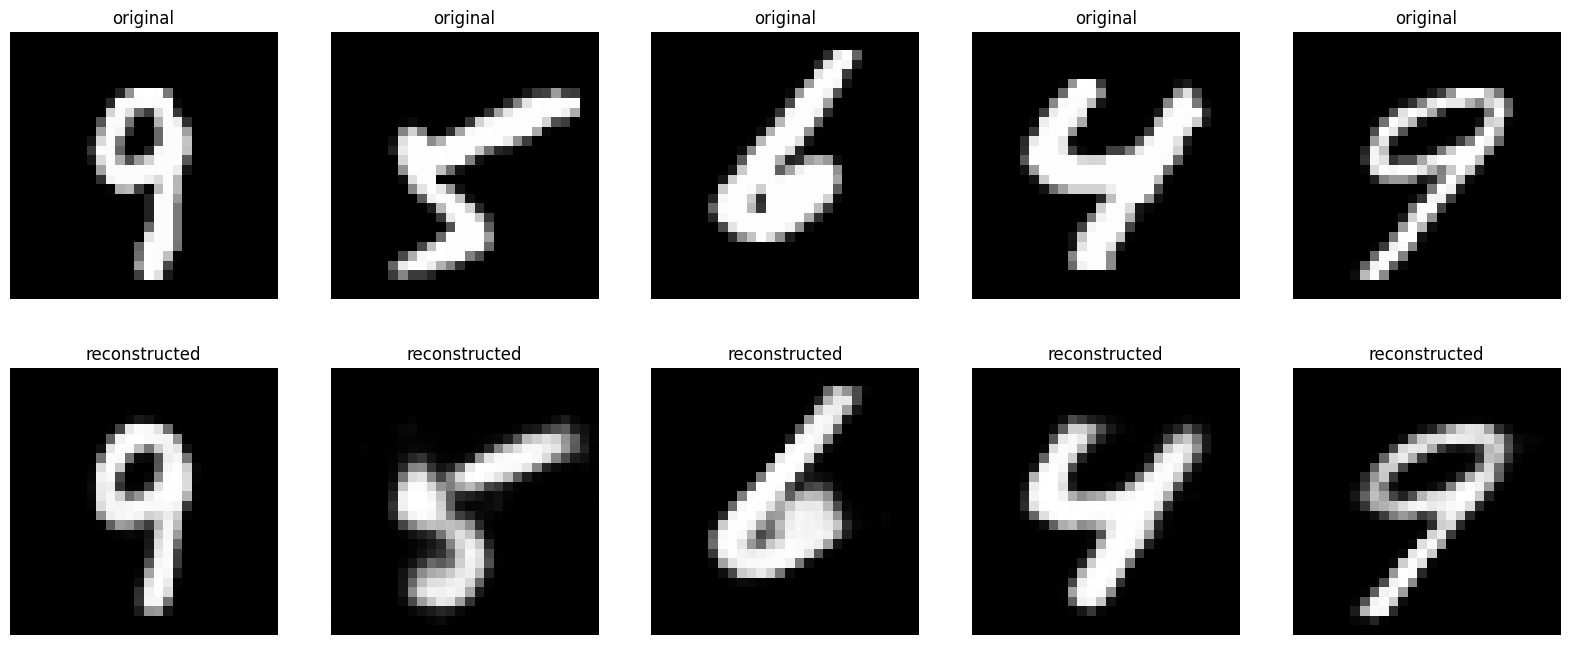

In [5]:
with torch.no_grad():
    test_images, _ = next(iter(train_loader))
    test_images = test_images.to(device)
    reconstructed_images = decoder(encoder(test_images))
    displaySamples(5, original=test_images.cpu(), reconstructed=reconstructed_images.cpu())

100%|██████████| 938/938 [00:04<00:00, 229.60it/s]


Epoch [1/10], Loss: 0.4548


100%|██████████| 938/938 [00:04<00:00, 229.14it/s]


Epoch [2/10], Loss: 0.4436


100%|██████████| 938/938 [00:04<00:00, 226.72it/s]


Epoch [3/10], Loss: 0.4346


100%|██████████| 938/938 [00:04<00:00, 231.86it/s]


Epoch [4/10], Loss: 0.4172


100%|██████████| 938/938 [00:04<00:00, 230.98it/s]


Epoch [5/10], Loss: 0.4216


100%|██████████| 938/938 [00:04<00:00, 233.80it/s]


Epoch [6/10], Loss: 0.4234


100%|██████████| 938/938 [00:04<00:00, 231.95it/s]


Epoch [7/10], Loss: 0.4230


100%|██████████| 938/938 [00:03<00:00, 237.26it/s]


Epoch [8/10], Loss: 0.4297


100%|██████████| 938/938 [00:04<00:00, 234.13it/s]


Epoch [9/10], Loss: 0.4204


100%|██████████| 938/938 [00:03<00:00, 235.27it/s]

Epoch [10/10], Loss: 0.4197


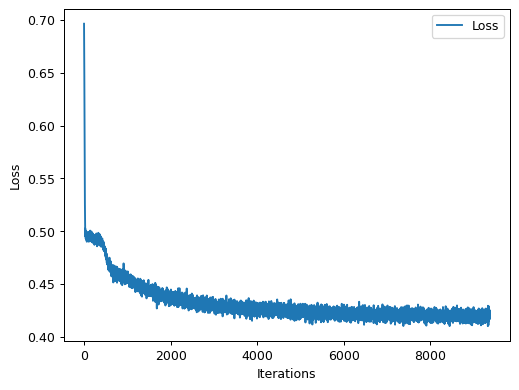

In [6]:
learning_rate = 0.001
epochs = 10
denoiser = Denoiser(learning_rate).to(device)
criterion = nn.BCELoss()
losses = []
def one_hot_encode(labels):
    
    num_classes = 10
    
    
    onehot_labels = torch.zeros((labels.shape[0], num_classes)).to(labels.device)
    
    
    onehot_labels.scatter_(1, labels.unsqueeze(1), 1)
    
    return onehot_labels.to(device)
for epoch in range(epochs):
    for data in tqdm(train_loader):
        
        images, labels = data
        oneHotLabels = one_hot_encode(labels)
        images = images.to(device)
        denoiser.optimizer.zero_grad()
        
        encoded = encoder(images)
        noise = torch.randn_like(encoded)  * 0.5
        predicted = denoiser(torch.sigmoid(encoded+noise))
        loss = criterion(predicted, encoded)
        loss.backward()
        losses.append(loss.item())
        denoiser.optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
ModelPersistence.save(denoiser)

plotLoss(losses)

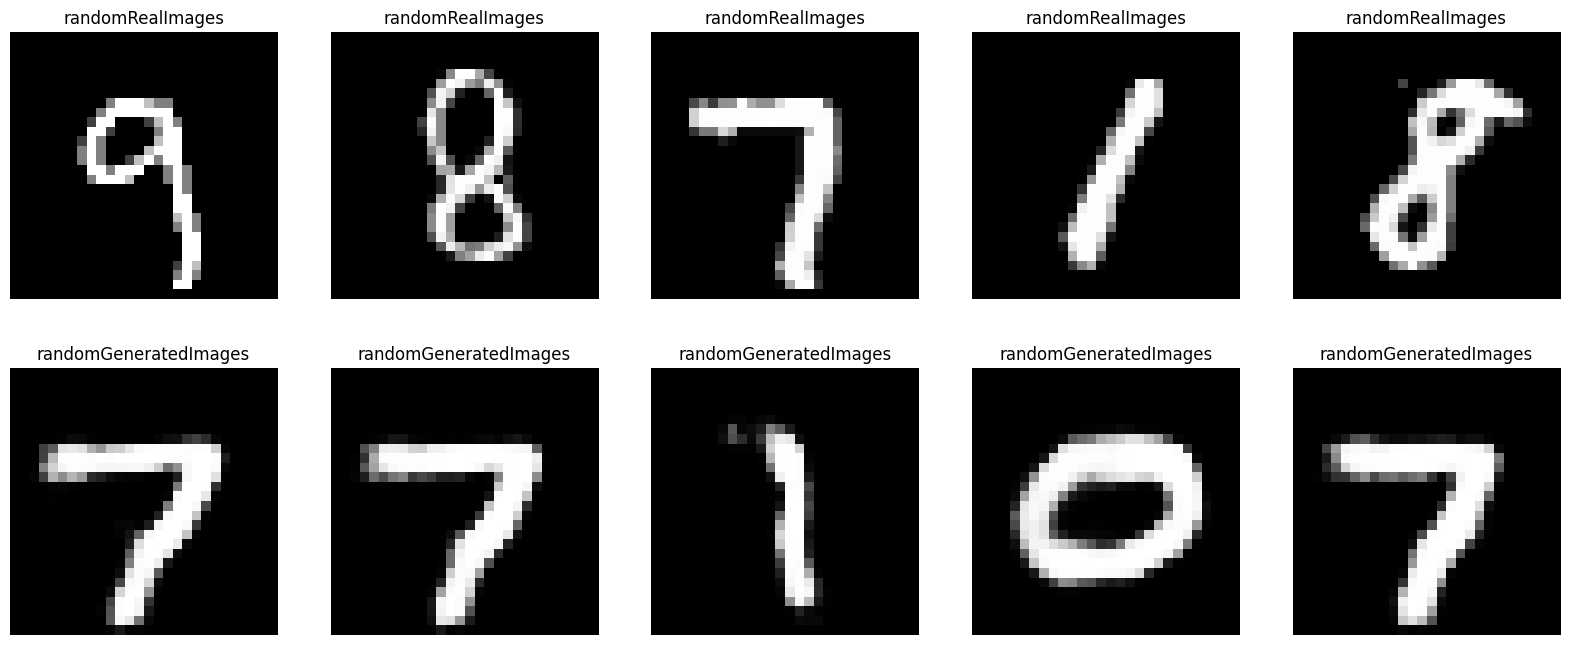

In [9]:
randomNoise = torch.randn((5, 128), device=device)

with torch.no_grad():
    
    test_images, _ = next(iter(train_loader))
    test_images = test_images.to(device)

    out = randomNoise
    for i in range(10):
        out = denoiser(out)

    generatedImages = decoder(out)

    displaySamples(5, randomRealImages=test_images.cpu(), randomGeneratedImages=generatedImages.cpu())

In [8]:
denoiser = ModelPersistence.load(Denoiser)
encoder = ModelPersistence.load(Encoder)
decoder = ModelPersistence.load(Decoder)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_19640\1767663296.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(result.path)
